***입력: 이미지 --> 네이버 클로바 OCR 적용 --> 결과 bbox, confidence 출력***

*텍스트가 포함된 이미지 파일을 API 게이트웨이(Gateway)를 통해 전송합니다. 인보크(Invoke) URL을 통해 OCR 서비스에 전달*

* **데이터:** 영수증 Offline(raw), Online(structured)


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


### 1. Settings

In [ ]:
import os
import sys

base_dir = "/content/gdrive/MyDrive/Workspace/Colab"
sys.path.append(base_dir)

src_dir = os.path.join(base_dir, "ocr")
%cd $src_dir

/content/gdrive/MyDrive/Workspace/Colab/ocr


In [ ]:
!pip install -r requirements.txt > /dev/null

In [ ]:
import getpass
from dotenv import load_dotenv

# .env 파일 로드
load_dotenv()

def get_env_variable(var_name, prompt_message) -> str:
    """
    환경 변수 가져오거나,
    없으면 사용자입력
    """
    value = os.getenv(var_name)
    if not value:
        value = getpass.getpass(prompt_message)

    return value

In [ ]:
OCR_SECRET_KEY = get_env_variable("OCR_SECRET_KEY", "Enter your OCR_SECRET_KEY: ")
APIGW_URL = get_env_variable("APIGW_INVOKE_URL", "Enter your APIGW_INVOKE_URL: ")

if not OCR_SECRET_KEY:
    raise ValueError("OCR SECRET KEY not found in .env file.")
if not APIGW_URL:
    raise ValueError("APIGW INVOKE URL not found in .env file.")

### 2. OCR Test

* *이미지 전처리 --> Text Detection `boundingPoly` --> Text Recognition
`inferText`*
  + *`boundingPoly`는 v2에만 제공*
  + *`boundingPoly`의 `vertices`은 4좌표(좌상단, 우상단, 우하단, 좌하단)으로 표현*
* [Naver Clova OCR API](https://api.ncloud-docs.com/docs/ai-application-service-ocr-ocr)

In [ ]:
import import_ipynb
from utils.file_signature_util import FileSignatureUtil

In [ ]:
from google.colab import files

# 파일 업로드
uploaded = files.upload()
for file_name, file_content in uploaded.items():
    print(f"File name: {file_name}")

image_files = list(uploaded.keys())

Saving Offline.jpg to Offline (1).jpg
Saving Online.png to Online (1).png
File name: Offline (1).jpg
File name: Online (1).png


In [ ]:
import time
import uuid
import json
import requests
from requests.exceptions import RequestException


def generate_request_message(file_type) -> dict:
    """
    API 요청 message 생성

    :param file_type: 파일 타입
    :return: JSON 형태의 요청 message
    """
    return {
        'version': 'V2',
        'requestId': str(uuid.uuid4()),
        'timestamp': int(round(time.time() * 1000)),
        "lang": "ko",
        'images': [
            {
                'format': file_type,
                'name': 'test'
            }
        ],
        "enableTableDetection": False
    }

In [ ]:
def send_multipart_request(secret_key, api_url, image_file, request_message) -> requests.Response:
    """
    멀티파트 형식으로 OCR API 요청
    """
    try:

        image_file_type = image_file.split('.')[-1]

        with open(image_file, 'rb') as f:

            files = {
                'file': (image_file, f, f'application/{image_file_type}')
            }
            data = {
                'message': json.dumps(request_message).encode('UTF-8')
            }
            headers = {
                'X-OCR-SECRET': secret_key
            }

            response = requests.post(api_url, headers=headers, data=data, files=files)

        return response
    except FileNotFoundError:
        return None
    except RequestException as e:
        return None
    except Exception as e:
        return None

*Content-Type*
  + `application/json`
  + `multipart/form-data`

*이미지 세부정보*
  + JSON Array로 작성
  + 호출당 1개의 이미지 Array 작성 가능
  + 이미지 크기: 최대 50 MB
  + 이미지 형식: `jpg`, `jpeg`, `png`, `pdf`, `tif`, `tiff`
    - `pdf`: 최대 10 페이지 인식 가능

In [ ]:
def pretty_print_json(byte_data) -> None:
    """
    pretty print
    """
    decoded_data = byte_data.decode('utf-8')
    data = json.loads(decoded_data)

    pretty_json = json.dumps(data, indent=4)
    print(pretty_json)

In [ ]:
import cv2
import matplotlib.pyplot as plt

In [ ]:
def handle_ocr_response(response, image) -> None:
    """
    응답 처리
    """
    ocr_result = json.loads(response.text.encode('utf8'))

    all_texts = []
    annotations = []
    highlighted_image = image.copy()

    # OCR 이미지 결과 처리
    for image_result in ocr_result['images']:

        for field in image_result['fields']:
            text = field['inferText']
            confidence = field.get('inferConfidence', 'N/A')
            bounding_box = field['boundingPoly']['vertices']

            all_texts.append(f"Text: {text}, Confidence: {confidence}")
            draw_bounding_box(bounding_box, highlighted_image)

    display_results(image, highlighted_image)

    print("----------------------------------------")
    print("OCR Results:")
    for idx, text in enumerate(all_texts, start=1):
        print(f"{idx}. {text}")


def draw_bounding_box(bounding_box, image) -> None:
    """
    BBox
    """
    x_min, y_min = int(bounding_box[0]['x']), int(bounding_box[0]['y'])
    x_max, y_max = int(bounding_box[2]['x']), int(bounding_box[2]['y'])

    cv2.rectangle(image, (x_min, y_min), (x_max, y_max), color=(0, 255, 0), thickness=2)


def display_results(image, highlighted_image) -> None:
    """
    OCR 결과, 원본 이미지 출력
    OCR 인식 결과 텍스트와 highlighed bbox 까지 출력
    """
    fig, axs = plt.subplots(1, 2, figsize=(15, 10))
    axs[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axs[0].set_title('Original Image')
    axs[0].axis('off')

    axs[1].imshow(cv2.cvtColor(highlighted_image, cv2.COLOR_BGR2RGB))
    axs[1].set_title('Highlighted Image')
    axs[1].axis('off')

    plt.show()

In [ ]:
def perform_ocr(image_file, file_type) -> any:
    """
    OCR 요청 수행
    """
    request_message = generate_request_message(file_type)
    return send_multipart_request(OCR_SECRET_KEY, APIGW_URL, image_file, request_message)

File Offline (1).jpg is a valid jpg file.


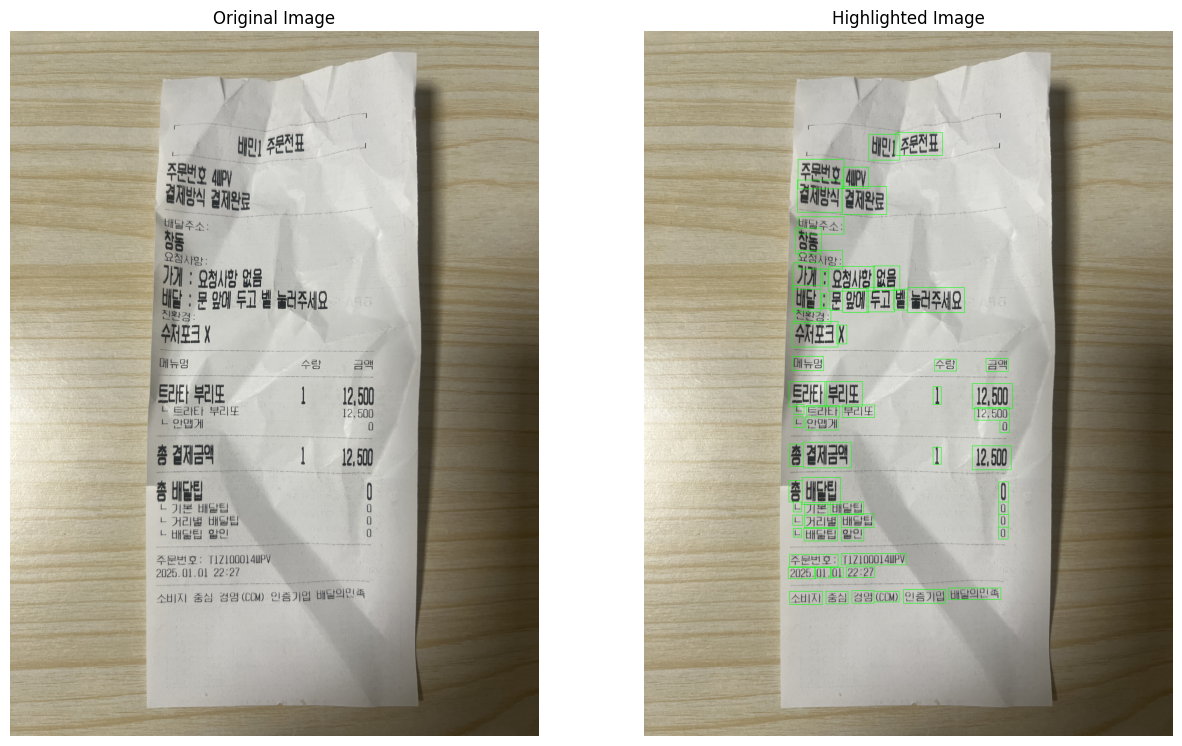

----------------------------------------
OCR Results:
1. Text: 배민1, Confidence: 0.9969
2. Text: 주문전표, Confidence: 1.0
3. Text: 주문번호, Confidence: 1.0
4. Text: 4WPV, Confidence: 0.9992
5. Text: 결제방식, Confidence: 0.9999
6. Text: 결제완료, Confidence: 0.9998
7. Text: 배달주소:, Confidence: 0.9997
8. Text: 창동, Confidence: 0.998
9. Text: 요청사항:, Confidence: 0.9981
10. Text: 가게, Confidence: 0.9999
11. Text: ··, Confidence: 0.8933
12. Text: 요청사항, Confidence: 0.9985
13. Text: 없음, Confidence: 1.0
14. Text: 배달, Confidence: 1.0
15. Text: . ., Confidence: 0.7366
16. Text: 문, Confidence: 0.9999
17. Text: 앞에, Confidence: 1.0
18. Text: 두고, Confidence: 1.0
19. Text: 벨, Confidence: 0.987
20. Text: 눌러주세요, Confidence: 0.9952
21. Text: 친환경:, Confidence: 0.9966
22. Text: 수저포크, Confidence: 0.9986
23. Text: X, Confidence: 0.5451
24. Text: 메뉴명, Confidence: 0.9999
25. Text: 수량, Confidence: 0.9999
26. Text: 금액, Confidence: 1.0
27. Text: 트라타, Confidence: 0.9996
28. Text: 부리또, Confidence: 0.9986
29. Text: 1, Confidence: 1.

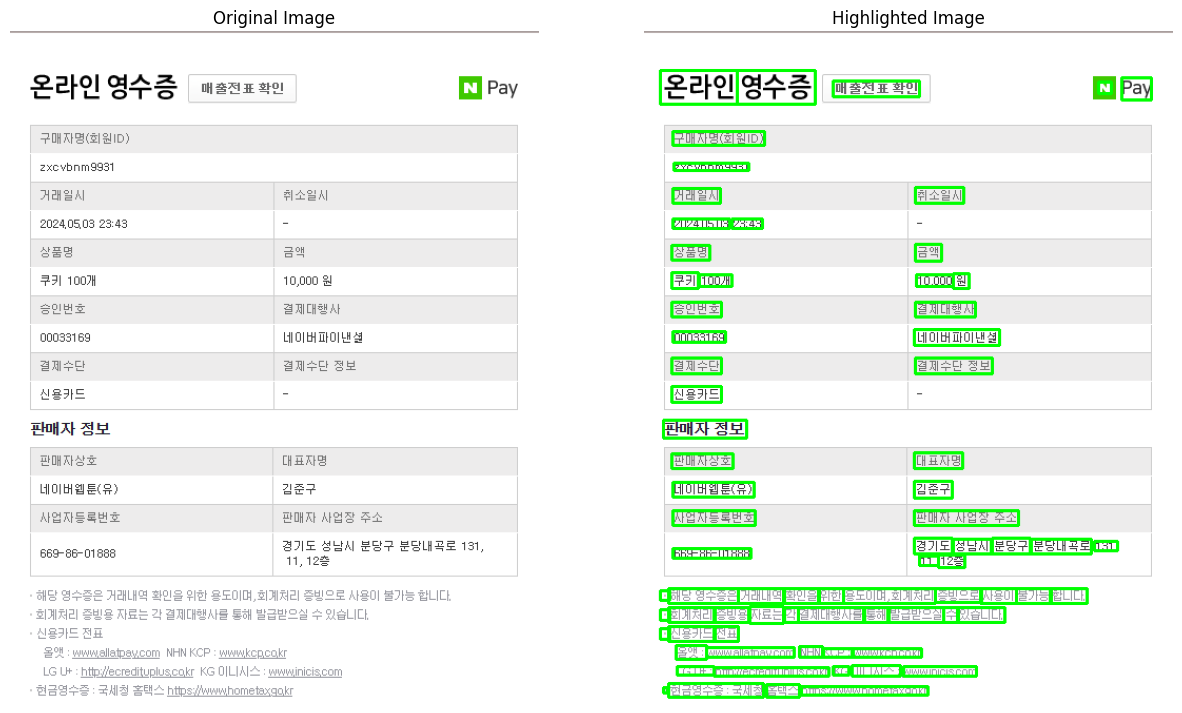

----------------------------------------
OCR Results:
1. Text: 온라인, Confidence: 1.0
2. Text: 영수증, Confidence: 1.0
3. Text: 매출전표확인, Confidence: 0.9787
4. Text: N, Confidence: 0.9988
5. Text: Pay, Confidence: 0.9995
6. Text: 구매자명(회원ID), Confidence: 0.9907
7. Text: zxcvbnm9931, Confidence: 0.962
8. Text: 거래일시, Confidence: 1.0
9. Text: 취소일시, Confidence: 0.9989
10. Text: 2024.05.03, Confidence: 0.9998
11. Text: 23:43, Confidence: 0.9998
12. Text: 상품명, Confidence: 0.9999
13. Text: 금액, Confidence: 1.0
14. Text: 쿠키, Confidence: 1.0
15. Text: 100개, Confidence: 0.9998
16. Text: 10.000, Confidence: 0.9327
17. Text: 원, Confidence: 1.0
18. Text: 승인번호, Confidence: 1.0
19. Text: 결제대행사, Confidence: 0.9997
20. Text: 00033169, Confidence: 0.9929
21. Text: 네이버파이낸셜, Confidence: 0.9999
22. Text: 결제수단, Confidence: 0.9999
23. Text: 결제수단정보, Confidence: 0.9863
24. Text: 신용카드, Confidence: 1.0
25. Text: 판매자 정보, Confidence: 0.9826
26. Text: 판매자상호, Confidence: 0.9989
27. Text: 대표자명, Confidence: 0.9999
28. Text: 네이

In [ ]:
# 파일별
for image_file in image_files:

    try:
        # 파일 읽기
        image = cv2.imread(image_file)
        if image is None:
            continue

        # 매직 넘버 검증
        file_type = FileSignatureUtil.get_file_type(image_file)
        if not file_type:
            continue

        print(f"File {image_file} is a valid {file_type} file.")

        # OCR 수행
        response = perform_ocr(image_file, file_type)

        if response.status_code == 200:
            # print(pretty_print_json(response.text.encode('utf8')))
            handle_ocr_response(response, image)
        else:
            print(response.status_code)
            print(response.text)
            continue
    except ValueError as e:
        print(e)

*응답 Body*

| 필드           | 타입     | 필수 여부 | 설명                                                                 |
|----------------|---------|----------|----------------------------------------------------------------------|
| **version**    | String  | -        | 버전 정보                                        |
| **requestId**  | String  | -        | API 호출 UUID                                                       |
| **timestamp**  | Integer | -        | API 호출 시각                                            |
| **images**     | Array   | -        | `images` 세부 정보  



*images 세부정보*  

| 필드                        | 타입        | 필수 여부 | 설명                                                                 |
|----------------------------|------------|----------|----------------------------------------------------------------------|
| **uid**                     | String     | -        | 이미지 UID (API 유효성 검사 및 요청 추적 시 사용)                   |
| **name**                    | String     | -        | 이미지 이름 (이미지 식별 및 응답 결과 확인 시 사용)                |
| **inferResult**             | String     | -        | 이미지 인식 결과 (`SUCCESS`, `FAILURE`, `ERROR`)                   |
| **message**                 | String     | -        | 결과 메시지                                                         |
| **validationResult**        | Object     | -        | 유효성 검사 결과 정보                                               |
| **validationResult.result** | String     | -        | 유효성 검사 결과 코드 (`NO_REQUESTED`, `UNCHECKED`, `ERROR`, `VALID`, `INVALID`) |
| **validationResult.message**| String     | -        | 유효성 검사 결과 세부 메시지 (항상 응답되는 값은 아님)              |
| **convertedImageInfo**      | Object     | -        | 변환 이미지 정보 (형식이 `pdf` 또는 `tiff`일 때)                   |
| **convertedImageInfo.width**| Integer    | -        | 변환 이미지 가로 길이                                               |
| **convertedImageInfo.height**| Integer   | -        | 변환 이미지 세로 길이                                               |
| **convertedImageInfo.pageIndex**| Integer| -        | 변환 이미지 페이지 인덱스                                           |
| **convertedImageInfo.longImage**| Boolean| -        | 변환 이미지 길이 Long 여부 (`true` | `false`)                       |
| **combineResult**           | Object     | -        | 이미지 인식 결과 결합 정보                                          |
| **combineResult.name**      | String     | -        | 이미지 결합 필드 이름                                               |
| **combineResult.text**      | String     | -        | 각 이미지 필드별 출력값 및 고정 텍스트                             |
| **tables**                  | Array      | -        | 테이블 세부 정보                                                     |
| **fields**                  | Array      | -        | 필드 세부 정보                                                       |
